<a href="https://colab.research.google.com/github/ayoubbensakhria/finance_algo/blob/master/ARMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An ARMA model, or Autoregressive Moving Average model, is used to describe weakly stationary stochastic time series in terms of two polynomials. The first of these polynomials is for autoregression, the second for the moving average.

Often this model is referred to as the ARMA(p,q) model; where:

* p is the order of the autoregressive polynomial,
* q is the order of the moving average polynomial.

The equation is given by:

\begin{align}
        \mathbf{x_t} = \mathbf{w_t} + \sum_{i=1}^q \alpha_i x_{t-i} + \sum_{i=1}^p \beta_i w_{t-i}
        &
    \end{align}


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from time import time
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Vizualise the Stock Price Over Time

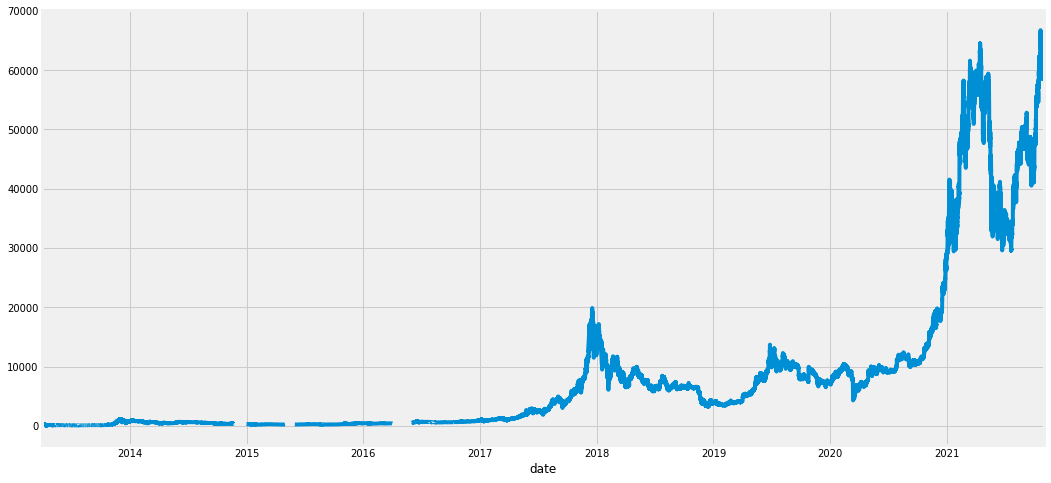

In [3]:
#read data
df = pd.read_csv('/content/drive/MyDrive/Yoctobe Fintech/Datasets/btcusd30mn.csv', parse_dates=True)
df.head()
# #setting index as date because some statsmodels might not work
df.rename(columns={'datetime': 'date'}, inplace=True)
df.index = df['date']
df.index = pd.to_datetime(df.index)
#plot
df['close'].plot(figsize=(16,8))

In [4]:
df = df.drop(columns =['open', 'high', 'low', 'volume', 'date'])
df.head()

,close
date,
2013-04-01 00:00:00,94.120499
2013-04-01 00:30:00,93.250000
2013-04-01 01:00:00,93.422576
2013-04-01 01:30:00,93.100000
2013-04-01 02:00:00,93.189997


# Identify the correct ARMA Model Order
## Visualising ACF Plot and PACF Plots
The bars inside the blue shaded region then they are not statistically significant.
* PACF is the autocorrelation that is just associated with just k lags
* PACF cuts off after lag k = q; ACF cuts off after lag k = p; 

"Cuts off" means that it becomes zero abruptly, and "tails off" means that it decays to zero asymptotically (usually exponentially).

The PACF "cuts off" after the 2nd lag, while the ACF "tails off" to zero. You probably have something like an AR(2).



In [5]:
# Training dataset ( = 2/3 of the original dataframe)
df = df.resample("D").mean()
# using a range of dates
mask = (df.index > '2019-03-01') & (df.index <= '2021-03-01')
df = df.loc[mask]

From the ACF and PACF we have p = 2, q = 0

# Tain Dataset

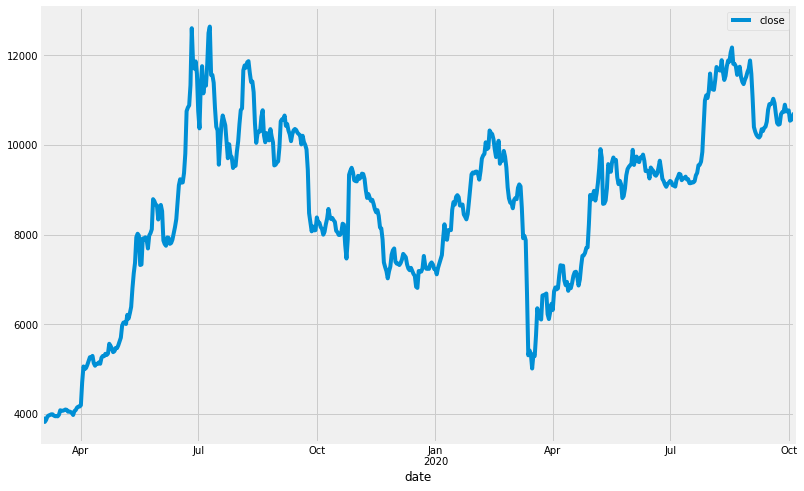

In [6]:
df_train, df_valid = train_test_split(df, train_size = 0.8, shuffle=False)
df_train.plot(figsize=(12,8))

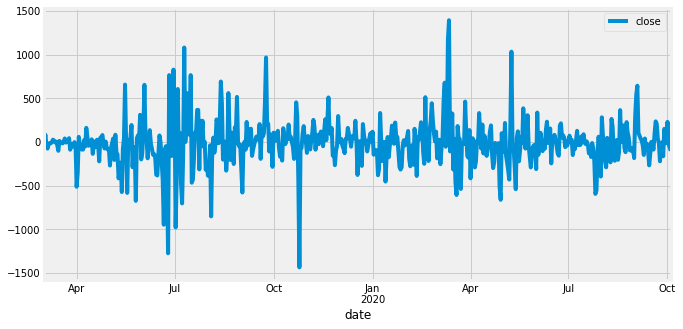

In [7]:

df_train.shift(-1).head(5)
# Difference the stock price and make it stationary
#A stationary process has the property that the mean, variance and autocorrelation structure do not change over time.
df1_train = df_train - df_train.shift(-1)
df1_train.dropna(inplace=True)
df1_train.plot(figsize = (10,5))


# Stationarity
Mathimatically, stationarity of a time series is defined as the requirement that for every m and n, the distributions: \begin{align}
        \mathbf (Y_1, Y_2, Y_3, ..., Y_n) \\and\\  (Y_{1+m}, Y_{2+m}, Y_{3+m}, ..., Y_{n+m})
        &
    \end{align} are the same.

Strong stationarity : all the aspects of the stochastic process remain unchanged, constant in time.
Weak stationarity : only mean, variance, and covariance remain unchanged.
The simplest example of weakly stationary process is White Noise defined with increasingly restrictive assumptions: 
\begin{align}
 \mathbf E(Y_t) = {μ} \\  Var(Y_t) = σ^2 \\  Cov(Y_t, Y_s) = 0
        &
    \end{align}

Where the best predictor is the Mean.

In [8]:
#test stationarity
print('Results of Dickey-Fuller Test:')
dftest = sm.tsa.adfuller(df1_train['close'])
dfoutput = pd.Series(dftest[0:4], 
                     index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -1.236961e+01
p-value                        5.317926e-23
#Lags Used                     2.000000e+00
Number of Observations Used    5.800000e+02
Critical Value (1%)           -3.441675e+00
Critical Value (5%)           -2.866536e+00
Critical Value (10%)          -2.569431e+00
dtype: float64


# Plot ACF PACF

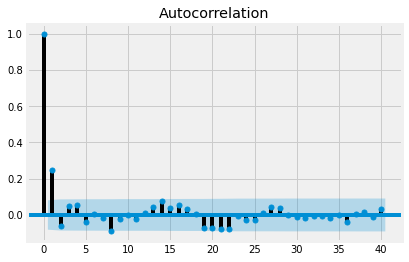

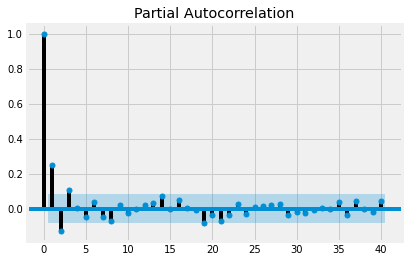

In [9]:
acf = sm.tsa.graphics.plot_acf(df1_train['close'], lags=40)
pacf = sm.tsa.graphics.plot_pacf(df1_train['close'], lags=40)

In [10]:
#By selecting aic as criteria, decide the order.
sm.tsa.stattools.arma_order_select_ic(df1_train['close'], ic='aic')

{'aic':              0            1            2
 0  8126.341575  8080.721174  8079.873145
 1  8091.299196  8080.121140  8081.871050
 2  8083.459776  8081.595353  8079.927925
 3  8079.077465  8081.073492  8079.120149
 4  8081.070132  8082.373547  8081.077922, 'aic_min_order': (3, 0)}

In [11]:
#fit the model_1
mod = sm.tsa.ARIMA(df_train, order = (3,1,2), freq='D')
result = mod.fit()
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  583
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -4032.560
Method:                       css-mle   S.D. of innovations            244.159
Date:                Wed, 10 Nov 2021   AIC                           8079.120
Time:                        14:22:22   BIC                           8109.697
Sample:                    03-03-2019   HQIC                          8091.039
                         - 10-05-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            11.7385     12.801      0.917      0.360     -13.352      36.829
ar.L1.D.close    -0.6925      0.246     -2.812      0.005      -1.175      -0.210
ar.L2.D.close    -0.5063      0.104     

In [13]:
#fit the model_1
mod1 = sm.tsa.ARIMA(df_train, order = (2,1,2), freq='D')
result1 = mod1.fit()
print(result1.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  583
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4033.964
Method:                       css-mle   S.D. of innovations            244.752
Date:                Wed, 10 Nov 2021   AIC                           8079.928
Time:                        14:22:38   BIC                           8106.137
Sample:                    03-03-2019   HQIC                          8090.144
                         - 10-05-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            11.7309     12.013      0.976      0.329     -11.815      35.276
ar.L1.D.close    -0.7842      0.185     -4.237      0.000      -1.147      -0.421
ar.L2.D.close    -0.3927      0.131     

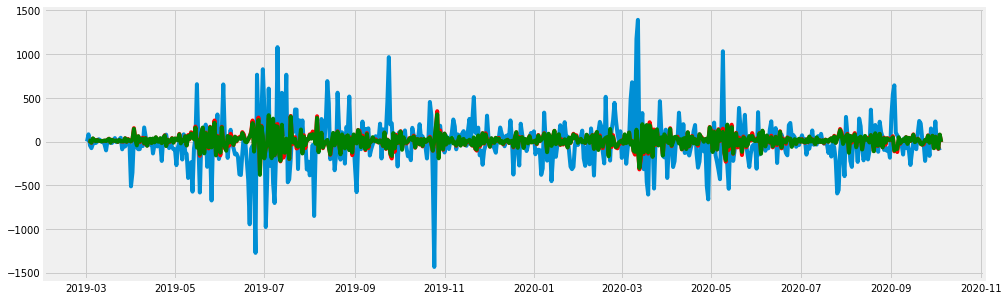

In [14]:
plt.figure(figsize=(15,5))
plt.plot(df1_train)
plt.plot(result.fittedvalues, color='red')
plt.plot(result1.fittedvalues, color='green')
plt.show()

In [17]:
#take back to original scale
df_estimated = pd.DataFrame(result.fittedvalues,columns=['close'],copy=False)
df_origin = df_estimated['close'] + df_train['close']
df_origin.dropna(inplace=True)

#take back to original scale model_2
df1_estimated = pd.DataFrame(result1.fittedvalues,columns=['close'],copy=False)
df1_origin = df1_estimated['close'] + df_train['close']
df1_origin.dropna(inplace=True)

plt.figure(figsize=(15,5))
plt.plot(df_train['close'])
plt.plot(df_origin)
plt.plot(df1_origin)
plt.show()

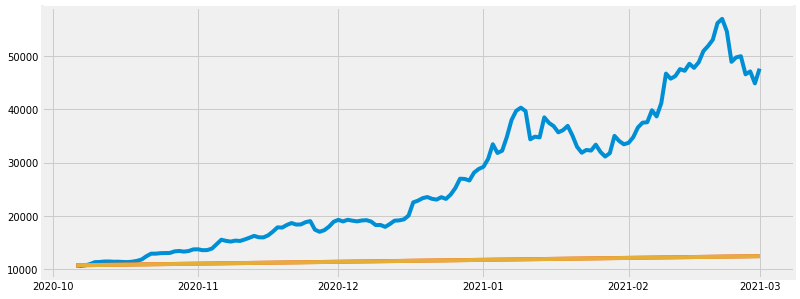

In [22]:
#make predictions and compared it to the validation dataset
forecast = pd.DataFrame(result.forecast(len(df_valid['close']))[0],
                        columns=['forecasted values'], index=df_valid.index)

#make predictions and compared it to the validation dataset
forecast1 = pd.DataFrame(result1.forecast(len(df_valid['close']))[0],
                        columns=['forecasted values'], index=df_valid.index)

plt.figure(figsize=(12,5))
plt.plot(df_valid['close'])
plt.plot(forecast['forecasted values'])
plt.plot(forecast1['forecasted values'])
plt.show()

In [25]:
df_diff = df - df.shift(-1)
df_diff.dropna(inplace = True)

#fit the model to the whole dataset
model_final = sm.tsa.ARIMA(df, order = (3,1,2), freq = 'D')
result_final = model_final.fit()
print(result_final.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  730
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -5738.175
Method:                       css-mle   S.D. of innovations            626.887
Date:                Wed, 10 Nov 2021   AIC                          11490.349
Time:                        14:31:55   BIC                          11522.501
Sample:                    03-03-2019   HQIC                         11502.753
                         - 03-01-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            60.0859     26.774      2.244      0.025       7.610     112.562
ar.L1.D.close    -0.1529      0.042     -3.624      0.000      -0.236      -0.070
ar.L2.D.close    -0.9425      0.024    -

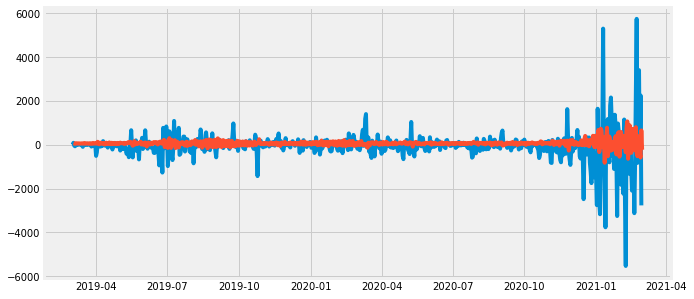

In [26]:
plt.figure(figsize=(10,5))
plt.plot(df_diff)
plt.plot(result_final.fittedvalues)
plt.show()

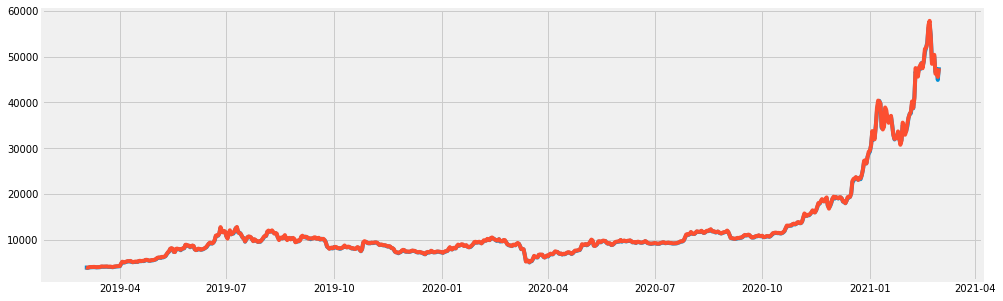

In [29]:
df_estimated_final = pd.DataFrame(result_final.fittedvalues,columns=['close'],copy=False)
df_origin_final = df_estimated_final['close'] + df['close']
df_origin_final.dropna(inplace=True)
plt.figure(figsize=(15,5))
plt.plot(df['close'])
plt.plot(df_origin_final)
plt.show()

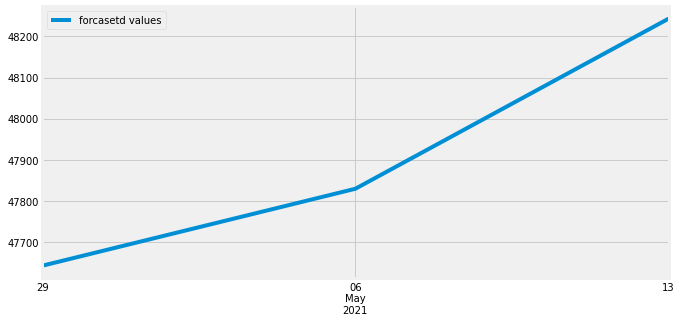

In [34]:
result_forecast = ['2021-04-29', '2021-05-06','2021-05-13']
result_forecast_index = pd.to_datetime(result_forecast)
result_forecast_index
forecast_final = pd.DataFrame(result_final.forecast(steps=3)[0], columns= ['forcasetd values'], index=result_forecast_index)
forecast_final['forcasetd values']
forecast_final.plot(figsize=(10,5))